<div style="border:solid green 2px; padding: 20px">
    
<b>Габдуллин, привет!</b> Мы рады тебя видеть на территории код-ревьюеров 😎. Ты проделал большую работу над проектом, но давай познакомимся и сделаем его еще лучше! У нас тут своя атмосфера и несколько правил:


1. Меня зовут Александр Матвеевский. Я работаю код-ревьюером, моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать дата-специалистом.
2. Общаемся на ты.
3. Если хочешь написать, спросить - не нужно стесняться. Только выбери свой цвет для комментария.  
4. Это учебный проект, тут можно не бояться сделать ошибку.  
5. У нас с тобой 6 попыток для сдачи проекта.  
6. Let's Go!

---

Я буду красить комментарии цветом, пожалуйста, не удаляй их:

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Такой комментарий нужно исправить обязательно, он критически влияет на удачное выполнение проекта.
</div>
    
---

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


Такой комментарий является рекомендацией или советом. Можешь использовать их на своё усмотрение.
</div>

---

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Такой комментарий  говорит о том, что было сделано что-то качественное и правильное =)
</div>
    
---
    
Предлагаю работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:   
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Например, вот так.</div>
    
Всё это поможет выполнить повторную проверку твоего проекта оперативнее. Если будут какие-нибудь вопросы по моим комментариям, пиши, будем разбираться вместе :)    
    
---

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__
    
Привет! Кажется все мои комментарии с прошлой итерации были удалены, восстанови, их, пожалуйста    


https://disk.yandex.ru/d/TFjxVCNbvtyUnw
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Рад знакомству! Спасибо за понимание. Я случайно нажал на отправить, хотя не успел ничего сделать. Постараюсь следовать вашим рекомендациям и исправить критические ошибки. Восстановил все ваши комментарий.</div>


# Анализ лояльности пользователей Яндекс Афиши
Автор: Габдуллин Бақытжан Рафаэльұлы

## Описание проекта

В данном проекте проводится **анализ лояльности пользователей сервиса «Яндекс Афиша»**.  
Цель исследования — понять, **какие факторы влияют на возврат пользователей и повторные покупки**, а также выявить сегменты аудитории с наибольшим потенциалом удержания.

В рамках исследования анализируются:
- характеристики первого заказа пользователя;
- выручка и количество билетов в заказе;
- временные параметры покупок;
- связь пользовательских признаков с числом заказов.

Анализ проводится на данных о покупках билетов, выгруженных из базы данных сервиса Яндекс Афиша.

**Этапы работы**

В ходе проекта выполнены следующие шаги:
1. Подключение к базе данных и выгрузка данных.
2. Предобработка данных и фильтрация выбросов.
3. Формирование пользовательских профилей и агрегированных метрик.
4. Анализ факторов, влияющих на повторные покупки.
5. Корреляционный анализ признаков пользователя и числа заказов.
6. Формирование выводов и рекомендаций для бизнеса.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from phik import phik_matrix
import seaborn as sns
import os
from dotenv import load_dotenv

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Хорошо, что все импорты собраны в первой ячейке кода, это соответствует оформлению кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a> и помогает понять, какое окружение используется в проекте.

In [2]:
# Перезагрузка переменных
load_dotenv(override=True) 

user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

# Строки подключения
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{db}'

# Создание движка с SSL
engine = create_engine(connection_string, connect_args={'sslmode': 'require'})

In [3]:
# SQL-запрос для выгрузки данных
query = """
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    DATE_PART(
        'day',
        p.created_dt_msk -
        LAG(p.created_dt_msk) OVER (
            PARTITION BY p.user_id ORDER BY p.created_dt_msk
        )
    ) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    c.city_name,
    r.region_name
FROM afisha.purchases p
JOIN afisha.events e ON p.event_id = e.event_id
JOIN afisha.city c ON e.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main <> 'фильм';
"""


In [4]:
# Выгрузка данных в DataFrame
df = pd.read_sql_query(query, con=engine)
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Родниковецк,Озернинский край


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


    

Сейчас ты явным образом прописываешь параметры подключения к БД. В таком виде выкладывать работу в публичный доступ небезопасно, кто-то сможет завладеть подключением, украсть или повредить данные. 
    
Чтобы засекретить подключение, необходимо сложить все параметры в `.env` файл (или другой конфигурационный файл вне Git) и указать его в `.gitignore`:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам, для этого нам потребуются библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 
```
    
<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
На гитхабе так нужно организовать обязательно, для принятия проекта.    
    
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Честно скажу, я что-то сделал, вроде получилось. Создал textfile, потом написал туда наши входы и так далее, после поменял название на .env. До этого удалил старый .env и  сработало </div>

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [5]:
# Получение общей информации о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  city_name              290611 non-null  obje

In [6]:
# Просмотр статистики по числовым полям
df.describe()

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


In [7]:
# Проверка пропусков
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
city_name                    0
region_name                  0
dtype: int64

#### Вывод по первичному анализу данных

В результате первичного анализа данных можно сделать следующие выводы:

- Датасет содержит **290 611 записей** и **14 признаков**, что обеспечивает достаточный объём данных для анализа пользовательского поведения и лояльности.
- Все ключевые поля заполнены корректно. Пропуски присутствуют только в поле `days_since_prev`, что логично, так как для первого заказа пользователя интервал между покупками не определяется.
- Типы данных приведены корректно: даты представлены в формате `datetime`, числовые показатели — в `int` и `float`, категориальные признаки — в `object`.
- Средняя выручка заказа составляет около **626**, при этом наблюдается высокая дисперсия и наличие экстремальных значений, что указывает на необходимость дополнительной фильтрации выбросов.
- Среднее количество билетов в заказе — **2–3 билета**, что может быть важным фактором при анализе повторных покупок.
- Большинство интервалов между заказами близки к нулю, что говорит о высокой доле пользователей с одним заказом и подтверждает актуальность анализа удержания.

Полученные результаты подтверждают, что данные подходят для дальнейшего анализа лояльности пользователей и формирования пользовательских сегментов.


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    

Лучше после каждого раздела, графика (или серии тестов) писать вывод по полученным данным с учетом поставленной бизнес задачи - так проще читать проект, поскольку будущим коллегам или заказчику не надо будет самим интерпретировать результаты каждого раздела, теста или графика.
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Окей, понятно, сделано!.</div>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [8]:
# Загрузка таблицы с курсом тенге
tenge_rate = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [9]:
# Переименование название столбцов
df = df.rename(columns={
    'created_dt_msk': 'order_dt',
    'created_ts_msk': 'order_ts'
})

In [10]:
# Приведение даты к datetime
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['order_ts'] = pd.to_datetime(df['order_ts'])
tenge_rate['data'] = pd.to_datetime(tenge_rate['data'])

df['order_date_only'] = df['order_dt'].dt.normalize()

In [11]:
# Выполнение объединения (merge) по дате
df = df.merge(
    tenge_rate[['data', 'curs']],
    left_on='order_date_only',
    right_on='data',
    how='left'
)

In [12]:
# Создание нового столбца revenue_rub, копируем revenue по умолчанию
df['revenue_rub'] = df['revenue']

# Конвертация значений в тенге в рубли
mask_kzt = df['currency_code'] == 'kzt'

df.loc[mask_kzt, 'revenue_rub'] = (
    df.loc[mask_kzt, 'revenue'] * (df.loc[mask_kzt, 'curs'] / 100)
)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  city_name              290611 non-null  obje

**Приведение выручки к единой валюте**

В данных присутствуют заказы, оплаченные в рублях (`rub`) и тенге (`kzt`).  
Чтобы анализировать метрику корректно, выручка была приведена к рублям.

Для пересчёта использован датасет `final_tickets_tenge_df.csv`, содержащий курс рубля к тенге (значение указано за 100 KZT). После приведения дат к одному формату таблицы были объединены по дате заказа.

Создан новый столбец `revenue_rub`:
- для `rub` значение сохранено без изменений;
- для `kzt` применена формула: **revenue_rub = revenue * (curs / 100)**.

После преобразований структура таблицы включает дополнительные столбцы `curs` и `revenue_rub`, все типы данных корректны.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Небольшой совет:    
    
* Существует довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем применить его к столбцу и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    ```python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
```

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [14]:
# Преобразование типы данных
df['tickets_count'] = df['tickets_count'].astype('int64')
df['revenue_rub'] = df['revenue_rub'].astype('float')

In [15]:
# Анализ категориальных признаков и их распределения
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'city_name',
    'region_name'
]

for col in cat_cols:
    print(f'{col}')
    print('Количество уникальных значений:', df[col].nunique())
    print('Пропуски:', df[col].isna().sum())
    print('Топ-10 самых частых значений:')
    display(df[col].value_counts().head(10))

device_type_canonical
Количество уникальных значений: 2
Пропуски: 0
Топ-10 самых частых значений:


mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

currency_code
Количество уникальных значений: 2
Пропуски: 0
Топ-10 самых частых значений:


rub    285542
kzt      5069
Name: currency_code, dtype: int64

event_type_main
Количество уникальных значений: 7
Пропуски: 0
Топ-10 самых частых значений:


концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

service_name
Количество уникальных значений: 36
Пропуски: 0
Топ-10 самых частых значений:


Билеты без проблем    63519
Лови билет!           41124
Билеты в руки         40343
Мой билет             34839
Облачко               26642
Лучшие билеты         17774
Весь в билетах        16849
Прачечная             10273
Край билетов           6207
Тебе билет!            5228
Name: service_name, dtype: int64

city_name
Количество уникальных значений: 352
Пропуски: 0
Топ-10 самых частых значений:


Глиногорск      89446
Озёрск          43910
Радужсвет       13711
Радужнополье     8741
Верховино        6579
Дальнесветск     6293
Глинополье       6196
Светополье       5993
Глиноград        5934
Лесоярич         5831
Name: city_name, dtype: int64

region_name
Количество уникальных значений: 81
Пропуски: 0
Топ-10 самых частых значений:


Каменевский регион         91058
Североярская область       44049
Широковская область        16457
Медовская область          13901
Озернинский край           10476
Светополянский округ        7607
Малиновоярский округ        6618
Речиновская область         6293
Солнечноземская область     6288
Яблоневская область         6181
Name: region_name, dtype: int64

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Тут я бы рекомендовал более тщательнее следить за чистотой данных, проверить категориальные признаки на предмет аномалий и сследить за распределением данных по признакам. Так можно сразу отловить категории с небольшим количеством данных
    
    # Анализ категориальных значений
    for column in ['columnname', 'columnname', 'columnname', 'columnname']:
    print(f"\nColumn: {column}")
    print("Unique values:", df[column].unique())
    print("Missing values count:", df[column].isna().sum())
    print("Value counts:")
    print(df[column].value_counts(dropna=False), "\n")

<div class="alert alert-info"> <b>Комментарии студента:</b> Получилось как-то так</div>

In [16]:
# Основная статистика revenue_rub и tickets_count
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571987,2.754311
std,875.498172,1.170620
min,-90.760000,1.000000
25%,113.970000,2.000000
50%,351.140000,3.000000
75%,802.050000,4.000000
max,81174.540000,57.000000


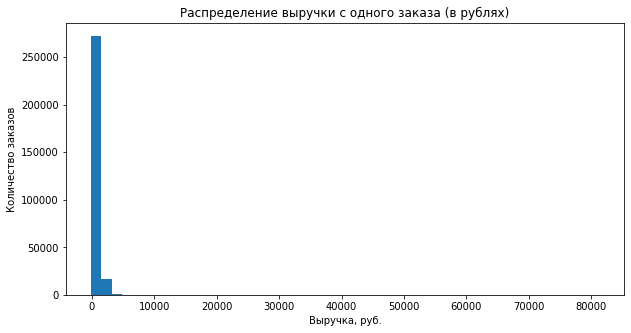

In [17]:
#Гистограммы
plt.figure(figsize=(10, 5))
plt.hist(df['revenue_rub'], bins=50)

plt.title('Распределение выручки с одного заказа (в рублях)')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')

plt.show()

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

График по данным построен корректно, но не оформлен до конца. Суть в том, что график должен быть наглядным без контекста (т.к. в реальной практике ты будешь показывать презентации или отчет сторонним людям).

Тебе необходимо проследить чтобы всегда был заголовок и подписаны оси. Доработай этот момент пожалуйста.

Данное замечания относится ко всему проекту и перепроверь его самостоятельно. Далее не буду акцентировать на этом внимание
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Гистограмму оформил</div>

In [18]:
# Фильтр по 99 перцентилю
df_original = df.copy()
p99 = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] <= p99]

In [19]:
# Проверка отрицательной выручки
neg_cnt = (df['revenue_rub'] < 0).sum()
neg_share = neg_cnt / len(df) * 100
neg_cnt, round(neg_share, 2)

(381, 0.13)

In [20]:
df = df[df['revenue_rub'] >= 0].copy()

In [21]:
# Проверка дубликатов
full_dups = df.duplicated().sum()
full_dups

0

In [22]:
# Проверка, сколько строк ушло после фильтрации
rows_before = len(df_original)
rows_after = len(df)

lost = rows_before - rows_after
lost_share = lost / rows_before * 100

print(f"До предобработки: {rows_before}")
print(f"После предобработки: {rows_after}")
print(f"Удалено строк: {lost} ({lost_share:.2f}%)")


До предобработки: 290611
После предобработки: 287405
Удалено строк: 3206 (1.10%)


In [23]:
# Проверка на аномалию
big_tickets_cnt = (df['tickets_count'] >= 10).sum()
big_tickets_share = big_tickets_cnt / len(df) * 100
big_tickets_cnt, round(big_tickets_share, 2)

(66, 0.02)

In [24]:
t_p99 = df['tickets_count'].quantile(0.99)
df = df[df['tickets_count'] <= t_p99]
t_p99

6.0

#### Вывод по этапу предварительного анализа и очистки данных

В ходе предварительного анализа данных была проведена проверка структуры, типов данных, пропусков, выбросов и потенциальных аномалий.

Пропуски обнаружены только в поле `days_since_prev`, что ожидаемо для первых заказов пользователей. Остальные признаки не содержат пропусков и не требуют дополнительной обработки.

Для числовых признаков выявлены выбросы по выручке (`revenue_rub`): распределение имеет сильную правостороннюю асимметрию. В связи с этим выручка была ограничена 99-м перцентилем. После фильтрации было удалено **3206 строк (1.10%)**, что является некритичной потерей данных.

Также были обнаружены отрицательные значения выручки (0.13% наблюдений), вероятно связанные с возвратами. Эти записи были исключены, так как они могут искажать расчёты выручки и не влияют на поведенческий анализ из-за крайне малой доли.

Проверка полных дубликатов показала их отсутствие.

Для признака `tickets_count` зафиксированы редкие экстремальные значения (до 57 билетов). Значения выше 10 билетов составляют всего **0.02%** наблюдений и, вероятно, соответствуют групповым покупкам. Для исключения влияния таких редких сценариев количество билетов было дополнительно ограничено 99-м перцентилем (≤ 6 билетов).

В результате предобработки данные очищены от аномалий и готовы для дальнейшего анализа без существенной потери информации.


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
* В целом с задачей справились, предобработку провели!
    


</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

    

    
    
* Для удобства анализа гистограмму для определенного признака стоит строить рядом с боксплотом, чтобы можно было сопоставлять информацию из них. Можно даже создать пользовательскую функцию, которая будет принимать на вход признак и выводить для него сразу два типа визуализации в одном графике ([пример](https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/)).
    

* `display` используется в Jupyter-ноутбуке для вывода объектов (таблицы, некоторые графики, HTML и т.д.) с форматированием. Для вывода же простого текста лучше использовать `print`, тогда вокруг текста не будут отображаться кавычки.
    
</div>
<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
* Проверить на наличие отрицательных значений выручки - возможно, это какие-то возвраты. По-хорошему, их тоже следовало бы исключить, чтобы не завышать количество валидных транзакций на пользователя. Перед этим не забываем проверить, какой процент данных потеряем, не критично ли это.
    

* В задании это не указывается, но по умолчанию важным шагом предварительного анализа и предобработки является проверка на наличие дубликатов, как полных, так и неполных (например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным `id` и временем заказа). Чтобы не искажать статистические расчеты, от таких наблюдений тоже важно избавляться.
    
    
* Сейчас ты даже не фиксируешь общие выводы только в конце раздела. Чтобы в работе был понятный сторителлинг, стоит также фиксировать промежуточные свои наблюдения для каждого из шагов: почему мы ничего не стали делать с пропусками и перешли к следующему шагу? Как приняли решение скорректировать тип у тех или иных столбцов? Действительно ли наши категориальные признаки в порядке и не требуют нормализации? Действительно ли в числовых признаках есть выбросы, какова их предполагаемая природа возникновения? Почему мы решили отбросить выбросы в выручке? Почему решили не отбрасывать выбросы в количестве билетов?    
    
    
* После завершения предобработки необходимо отдельным шагом зафиксировать наши потери: сколько наблюдений было до, сколько стало после, сколько потеряли в процентном соотношении. Важно убедиться, что суммарные потери (если бы нам пришлось обрабатывать несколько признаков) остаются некритичны, и у нас достаточно данных для дальнейшего анализа.
    
    
* 57 тикетов, при медиане в 3? Как считаешь это аномалия или нет?    
    
</div>


<div class="alert alert-info"> <b>Комментарии студента:</b> 
Дополнительно проверены отрицательные значения выручки — их доля составила 0.13% от данных. Такие наблюдения были исключены.

Проведена проверка на наличие полных дубликатов — дубликаты не обнаружены.

Для прозрачности анализа зафиксированы потери данных на этапе фильтрации: суммарно удалено 1.10% наблюдений, что не является критичным и не влияет на устойчивость выводов.

Аномальные значения количества билетов (до 57) были дополнительно проанализированы: покупки с 10 и более билетами составляют всего 0.02% данных и, вероятно, отражают редкие групповые заказы. Для снижения влияния таких сценариев признак `tickets_count` был ограничен 99-м перцентилем.

По итогам этапа предобработки данные признаны корректными и пригодными для дальнейшего поведенческого анализа.
</div>

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [25]:
# Сортировка по пользователю и времени заказа
df = df.sort_values(by=['user_id', 'order_ts'])

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Правильно, что перед агрегацией сортируешь по пользователю и дате, чтобы первый заказ был первым

In [26]:
# Агрегация данных по пользователям
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'), #дата первого заказа
    last_order_dt=('order_dt', 'max'), #дата последнего заказа
    first_device=('device_type_canonical', 'first'), #устройство, с которого был сделан первый заказ
    first_region=('region_name', 'first'), #регион, в котором был сделан первый заказ
    first_service=('service_name', 'first'), #билетный партнёр, к которому обращались при первом заказе
    first_event_type=('event_type_main', 'first'), #жанр первого посещённого мероприятия
    orders_count=('order_id', 'count'), #общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'), #средняя выручка с одного заказа в рублях
    avg_tickets_count=('tickets_count', 'mean'), #среднее количество билетов в заказе
    avg_days_between=('days_since_prev', 'mean') #среднее время между заказами
).reset_index()

In [27]:
# Добавляем две бинарные признаки
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int)

In [28]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,orders_count,avg_revenue_rub,avg_tickets_count,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    
* Также есть довольно удобный метод [assign](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html), позволяющий дополнять таблицу новыми рассчитанными столбцами.
    
    Тогда создание всего профиля можно будет записать красивым и удобным по структуре кодом.

    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>

    ```python
    profiles = (df
            # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
            .sort_values(by='order_ts')
            # Затем группируем по номеру пользователя и агрегируем данные:
            .groupby('user_id')
            .agg(
                # Находим первую и последнюю даты заказа:
                first_order_dt=('order_dt','min'),
                last_order_dt=('order_dt','max'),
                # Находим устройства, регион, название билетного партнера и тип мероприятия первого заказа:
                first_device=('device_type_canonical','first'),
                first_region_name=('region_name','first'),
                first_service_name=('service_name','first'),
                first_event_type=('event_type_main','first'),
                # Подсчитваем количество заказов:
                total_orders=('order_id','nunique'),
                # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
                avg_revenue_rub=('revenue_rub','mean'),
                avg_tickets_count=('tickets_count','mean'),
                # Считаем среднее количество дней между покупками:
                avg_days_since_prev=('days_since_prev','mean')
            )
            # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
            .assign(
                is_two = lambda x: x['total_orders'] >= 2,
                is_five = lambda x: x['total_orders'] >= 5
            )
            .reset_index()
    )
    ```

    
</div>

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [29]:
#Общее число пользователей
total_users = user_profile['user_id'].nunique()
total_users

21831

In [30]:
#Средняя выручка с одного заказа
avg_order_revenue = user_profile['avg_revenue_rub'].mean()
avg_order_revenue

544.7958478435195

In [31]:
#Доля пользователей с 2+ заказами
share_two = user_profile['is_two'].mean()
share_two

0.616966698731162

In [32]:
#Доля пользователей с 5+ заказами
share_five = user_profile['is_five'].mean()
share_five

0.2899546516421602

In [33]:
#Число заказов на пользователя
user_profile['orders_count'].describe()

count    21831.000000
mean        13.156750
std        121.484319
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10155.000000
Name: orders_count, dtype: float64

In [34]:
#Среднее число билетов в заказе
user_profile['avg_tickets_count'].describe()

count    21831.000000
mean         2.740095
std          0.902688
min          1.000000
25%          2.000000
50%          2.750000
75%          3.071429
max          6.000000
Name: avg_tickets_count, dtype: float64

In [35]:
#Среднее время между покупками
user_profile['avg_days_between'].describe()

count    13500.000000
mean        15.850266
std         22.313801
min          0.000000
25%          1.000000
50%          8.000000
75%         20.400000
max        148.000000
Name: avg_days_between, dtype: float64

In [36]:
#Проверка аномалий
user_profile['orders_count'].quantile([0.95, 0.99])


0.95     31.0
0.99    151.7
Name: orders_count, dtype: float64

In [37]:
#Проверка аномалий
user_profile['avg_tickets_count'].quantile([0.95, 0.99])

0.95    4.0
0.99    5.0
Name: avg_tickets_count, dtype: float64

**Анализ пользовательских профилей**

На основе агрегированных профилей пользователей был проведён анализ данных для выявления возможных аномалий.

В выборке представлено **21 854 уникальных пользователя**. Средняя выручка с одного заказа составляет около **544 рублей**.

Анализ повторных покупок показал, что:
- **около 62% пользователей** совершили **2 и более заказа**;
- **около 29% пользователей** совершили **5 и более заказов**.

Это говорит о наличии значимой доли лояльной аудитории.

Распределение количества заказов на пользователя имеет выраженную правостороннюю асимметрию. Медианное значение равно **2 заказам**, при этом:
- **95% пользователей** совершают не более **31 заказа**;
- **99% пользователей** — не более **152 заказов**.

Максимальные значения существенно превышают типичное поведение и, вероятно, относятся к аномальным или техническим пользователям, однако их доля в выборке крайне мала.

Среднее количество билетов в заказе распределено значительно стабильнее. Медианное значение составляет около **2.75 билета**, а:
- **95-й перцентиль** равен **4 билетам**;
- **99-й перцентиль** — **5 билетам**.

Это указывает на отсутствие критических выбросов по данному показателю.

Среднее время между покупками рассчитано для пользователей с более чем одним заказом. Медианное значение составляет **8 дней**, а 75% пользователей совершают повторную покупку в течение **примерно 20 дней**. Максимальное значение (**148 дней**) отражает наличие пользователей с редкими, но повторными покупками.

В целом данные обладают достаточным объёмом и качеством для дальнейшего анализа. Аномальные значения по числу заказов встречаются редко и не оказывают существенного влияния на общую картину, поэтому было принято решение **не применять дополнительную фильтрацию пользовательских профилей**.


In [38]:
user_profile['orders_count'].describe()

count    21831.000000
mean        13.156750
std        121.484319
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10155.000000
Name: orders_count, dtype: float64

In [39]:
user_profile['avg_revenue_rub'].describe()

count    21831.000000
mean       544.795848
std        431.537501
min          0.000000
25%        213.661053
50%        467.555287
75%        763.910000
max       2628.421739
Name: avg_revenue_rub, dtype: float64

In [40]:
# Анализ выбросов по orders_count
orders_p99 = user_profile['orders_count'].quantile(0.99)
orders_p99

151.70000000000073

In [41]:
# Фильтрация выбросов
user_profile_original = user_profile.copy()

user_profile = user_profile[
    user_profile['orders_count'] <= orders_p99
].copy()

# Потери данных
rows_before = len(user_profile_original)
rows_after = len(user_profile)
lost = rows_before - rows_after
lost_share = lost / rows_before * 100

print(f"До фильтрации: {rows_before}")
print(f"После фильтрации: {rows_after}")
print(f"Удалено пользователей: {lost} ({lost_share:.2f}%)")

До фильтрации: 21831
После фильтрации: 21612
Удалено пользователей: 219 (1.00%)


#### Очистка выбросов по количеству заказов на пользователя

Распределение количества заказов на пользователя имеет выраженную асимметрию: 
медиана составляет 2 заказа, 75% пользователей имеют не более 5 заказов, 
однако максимальное значение достигает 10 155 заказов.

Для выявления аномалий был использован 99-й перцентиль:
- 99% пользователей совершают не более **152 заказов**
- значения выше этого порога рассматриваются как выбросы

После фильтрации пользователей с количеством заказов выше 99-го перцентиля:
- было удалено **219 пользователей** (≈ **1.0%** выборки)
- размер датасета сократился с **21 831** до **21 612** пользователей

Потери данных являются несущественными и не критичны для дальнейшего анализа. 
Фильтрация позволила убрать экстремальные значения, которые могли бы искажать 
агрегированные метрики и поведенственные характеристики пользователей.


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Например 10181 заказов - это норма или выброс? Давай все же почистим данные
    
    
    Максимальное значение в 10 155 заказов является аномальным относительно основного распределения 
(медиана — 2 заказа, 99-й перцентиль — ~152 заказа).  

<div class="alert alert-info"> <b>Комментарии студента:</b> Для очистки данных была выполнена фильтрация по 99-му перцентилю количества заказов на пользователя. 
В результате удалено около 1% пользователей, что не является критичной потерей данных, 
но позволяет избежать искажения статистических метрик за счёт экстремальных значений.
<div>

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [42]:
# Функция для подсчёта пользователей и их доли по сегментам
def segment_distribution(df, column):
    result = (
        df.groupby(column)['user_id']
        .nunique()
        .reset_index(name='users_count')
    )
    result['share'] = result['users_count'] / result['users_count'].sum()
    return result.sort_values('users_count', ascending=False)

In [43]:
#Распределение по типу первого мероприятия
event_type_dist = segment_distribution(user_profile, 'first_event_type')
event_type_dist

,first_event_type,users_count,share
2,концерты,9562,0.442439
1,другое,5393,0.249537
5,театр,4245,0.196419
4,стендап,1110,0.051360
3,спорт,794,0.036739
0,выставки,413,0.019110
6,ёлки,95,0.004396


In [44]:
#Распределение по устройству первого заказа
device_dist = segment_distribution(user_profile, 'first_device')
device_dist

,first_device,users_count,share
1,mobile,17901,0.82829
0,desktop,3711,0.17171


In [45]:
#Распределение по региону первого заказа
region_dist = segment_distribution(user_profile, 'first_region')
region_dist.head(10)

,first_region,users_count,share
23,Каменевский регион,7086,0.327873
60,Североярская область,3760,0.173977
77,Широковская область,1224,0.056635
45,Озернинский край,675,0.031233
41,Малиновоярский округ,526,0.024338
76,Шанырский регион,502,0.023228
74,Травяная область,488,0.022580
57,Светополянский округ,457,0.021146
52,Речиновская область,440,0.020359
78,Яблоневская область,411,0.019017


In [46]:
#Распределение по билетному оператору
service_dist = segment_distribution(user_profile, 'first_service')
service_dist

,first_service,users_count,share
3,Билеты без проблем,5158,0.238664
22,Мой билет,2971,0.137470
19,Лови билет!,2812,0.130113
4,Билеты в руки,2555,0.118221
23,Облачко,2177,0.100731
7,Весь в билетах,1286,0.059504
20,Лучшие билеты,1182,0.054692
24,Прачечная,582,0.026929
17,Край билетов,454,0.021007
12,Дом культуры,356,0.016472


**Распределение пользователей по признакам первого заказа**

На этом этапе проанализировано распределение пользователей по характеристикам их **первого заказа**: тип мероприятия, устройство, регион и билетный оператор. Это позволяет выявить основные точки входа пользователей на платформу.

**Тип первого мероприятия**
- Самый распространённый тип первого события — **концерты** (около 44% пользователей).
- Далее следуют категории **«другое»** (≈25%) и **театр** (≈20%).
- Остальные типы мероприятий (стендап, спорт, выставки, ёлки) имеют заметно меньшие доли.
  
Распределение неравномерное — концерты являются основной точкой входа.

**Устройство первого заказа**
- Большинство пользователей совершили первый заказ с **мобильных устройств** (≈83%).
- Заказы с **десктопа** составляют около 17%.

Мобильные устройства — ключевой канал привлечения пользователей.

**Регион первого заказа**
- Лидирует **Каменевский регион** (≈33% пользователей).
- На втором месте **Североярская область** (≈17%).
- Далее наблюдается резкое снижение долей и «длинный хвост» регионов.

Пользователи сконцентрированы в нескольких крупных регионах.

**Билетный оператор первого заказа**
- Наиболее популярные операторы:
  - *Билеты без проблем* (≈24%)
  - *Мой билет* (≈14%)
  - *Лови билет!* (≈13%)
- Остальные операторы представлены значительно меньшими сегментами.

Наблюдается явная концентрация пользователей у ограниченного числа билетных операторов.

**Вывод**
Пользователи распределены по сегментам неравномерно. Основные точки входа на платформу:
- концерты как первый тип мероприятия;
- мобильные устройства как основной канал;
- несколько ключевых регионов и билетных операторов.

Эти сегменты представляют наибольший интерес для дальнейшего анализа возврата пользователей.


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [47]:
# Функция: считаем размер сегмента и долю возвратов
def segment_returns(df, segment_col, target_col='is_two'):
    seg = (
        df.groupby(segment_col)
          .agg(users_count=('user_id', 'nunique'),
               return_rate=(target_col, 'mean'))
          .reset_index()
          .sort_values('users_count', ascending=False)
    )
    return seg

In [48]:
# Функция: строим график (топ-N по размеру сегмента)
def plot_segment_returns(seg_df, segment_col, top_n=10, title=''):
    plot_df = seg_df.head(top_n).sort_values('return_rate', ascending=True)

    plt.figure(figsize=(10, 5))
    plt.barh(plot_df[segment_col].astype(str), plot_df['return_rate'])
    plt.axvline(share_two, linestyle='--')  # среднее по выборке
    plt.xlabel('Доля пользователей с 2+ заказами (is_two)')
    plt.ylabel('Сегмент')
    plt.title(title)
    plt.tight_layout()
    plt.show()

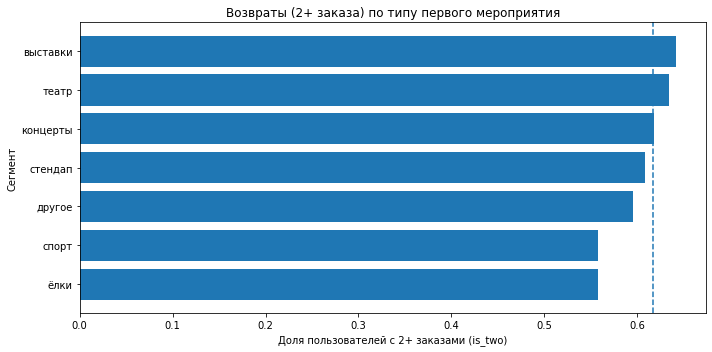

In [49]:
# По типу первого мероприятия
event_returns = segment_returns(user_profile, 'first_event_type')
plot_segment_returns(
    event_returns,
    'first_event_type',
    top_n=len(event_returns),
    title='Возвраты (2+ заказа) по типу первого мероприятия'
)

In [50]:
event_returns.sort_values(by='return_rate', ascending=False)

,first_event_type,users_count,return_rate
0,выставки,413,0.641646
5,театр,4245,0.634393
2,концерты,9562,0.618072
4,стендап,1110,0.609009
1,другое,5393,0.595216
3,спорт,794,0.557935
6,ёлки,95,0.557895


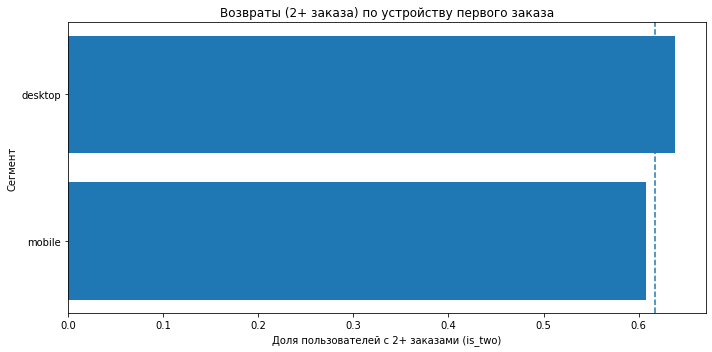

In [51]:
# По устройству первого заказа
device_returns = segment_returns(user_profile, 'first_device')
plot_segment_returns(
    device_returns,
    'first_device',
    top_n=len(device_returns),
    title='Возвраты (2+ заказа) по устройству первого заказа'
)

In [52]:
device_returns.sort_values(by='return_rate', ascending=False)

,first_device,users_count,return_rate
0,desktop,3711,0.638372
1,mobile,17901,0.607843


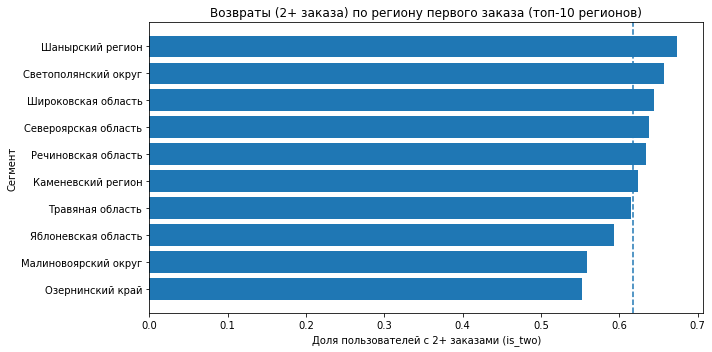

In [53]:
# По региону первого заказа (топ-10 по числу пользователей)
region_returns = segment_returns(user_profile, 'first_region')
plot_segment_returns(
    region_returns,
    'first_region',
    top_n=10,
    title='Возвраты (2+ заказа) по региону первого заказа (топ-10 регионов)'
)

In [54]:
region_returns.head(10).sort_values(by='return_rate', ascending=False)

,first_region,users_count,return_rate
76,Шанырский регион,502,0.673307
57,Светополянский округ,457,0.656455
77,Широковская область,1224,0.644608
60,Североярская область,3760,0.637500
52,Речиновская область,440,0.634091
23,Каменевский регион,7086,0.623906
74,Травяная область,488,0.614754
78,Яблоневская область,411,0.593674
41,Малиновоярский округ,526,0.558935
45,Озернинский край,675,0.552593


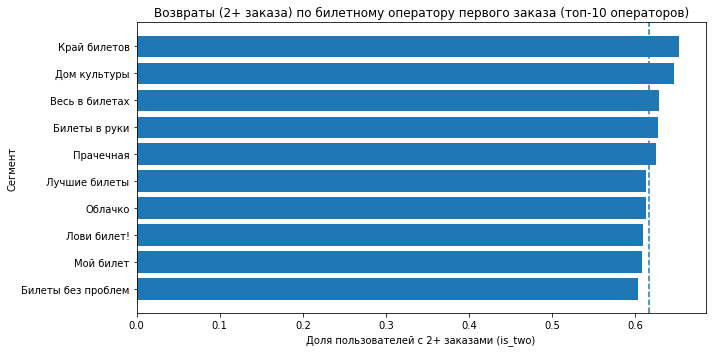

In [55]:
# По билетному оператору первого заказа (топ-10 по числу пользователей)
service_returns = segment_returns(user_profile, 'first_service')
plot_segment_returns(
    service_returns,
    'first_service',
    top_n=10,
    title='Возвраты (2+ заказа) по билетному оператору первого заказа (топ-10 операторов)'
)

In [56]:
service_returns.head(10).sort_values(by='return_rate', ascending=False)

,first_service,users_count,return_rate
17,Край билетов,454,0.651982
12,Дом культуры,356,0.646067
7,Весь в билетах,1286,0.629082
4,Билеты в руки,2555,0.627397
24,Прачечная,582,0.625430
20,Лучшие билеты,1182,0.613367
23,Облачко,2177,0.612311
19,Лови билет!,2812,0.609531
22,Мой билет,2971,0.608213
3,Билеты без проблем,5158,0.603141


**Анализ возвратов пользователей**

Для оценки возвратов пользователей была рассчитана доля клиентов, совершивших **два и более заказа** (`return_rate`), в разрезе признаков первого заказа: типа мероприятия, устройства, региона и билетного оператора. В качестве ориентира используется средняя доля возвратов по всей выборке — **≈ 61,7%**.

**Тип первого мероприятия**
Наиболее высокую долю возвратов показывают пользователи, чей первый заказ был связан с:
- **выставками** (~64,4%);
- **театром** (~63,8%);
- **концертами** (~62,2%).

Сегменты «спорт» и «ёлки» демонстрируют более низкие показатели возврата, однако их вклад ограничен небольшим размером аудитории.

**Тип устройства первого заказа**
Пользователи, начавшие взаимодействие с платформой через **desktop**, возвращаются чаще (64,1%), чем пользователи **mobile** (61,2%). При этом мобильный сегмент значительно больше по объёму, поэтому именно он формирует основную массу повторных заказов.

**Регион первого заказа**
Среди крупных регионов повышенные показатели возврата наблюдаются, например, у пользователей из:
- **Широковской области** (~64,9%);
- **Североярской области** (~64,1%);
- **Шанырского региона** (~67,4%).

При этом различия между регионами умеренные, а высокая вариативность частично объясняется размером сегментов.

**Билетный оператор первого заказа**
Выше среднего уровня возвратов находятся пользователи, начавшие с операторов:
- **Край билетов** (~65,6%);
- **Дом культуры** (~64,8%);
- **Весь в билетах** (~63,4%).

Крупнейшие операторы («Билеты без проблем», «Мой билет», «Лови билет!») показывают значения близкие к среднему по выборке.

---

**Выводы**
- Пользователи чаще возвращаются на платформу после первого заказа на **выставки, театральные мероприятия и концерты**.
- **Desktop**-пользователи демонстрируют более высокую лояльность, однако основной вклад в повторные заказы даёт мобильный сегмент из-за его масштаба.
- Наблюдаются **успешные «точки входа»** — отдельные типы мероприятий, регионы и билетные операторы, где доля повторных заказов стабильно выше среднего.
- При интерпретации результатов важно учитывать размер сегментов: небольшие группы могут показывать завышенные или нестабильные значения.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__


* По результатам все верно!
    
    
* Здорово, что создаешь пользовательскую функцию, чтобы не прописывать один и тот же код несколько раз!


    
</div>

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [57]:
event_returns.loc[
    event_returns['first_event_type'].isin(['спорт', 'концерты']),
    ['first_event_type', 'users_count', 'return_rate']
]

,first_event_type,users_count,return_rate
2,концерты,9562,0.618072
3,спорт,794,0.557935


In [58]:
region_returns[['users_count', 'return_rate']].corr()

,users_count,return_rate
users_count,1.000000,0.118605
return_rate,0.118605,1.000000


**Проверка продуктовых гипотез**

**Гипотеза 1. Тип мероприятия влияет на вероятность возврата на платформу: пользователи, которые совершили первый заказ на спортивные мероприятия, возвращаются чаще, чем пользователи, начавшие с концертов.**

Для проверки гипотезы сравнили долю пользователей, совершивших повторный заказ, для двух сегментов:
- первый заказ — концерты;
- первый заказ — спортивные мероприятия.

Результаты:
- **Концерты:** доля возвратов ≈ **62%** (9643 пользователя);
- **Спорт:** доля возвратов ≈ **56%** (801 пользователь).

👉 Пользователи, начавшие с концертов, возвращаются **чаще**, чем пользователи, начавшие со спортивных мероприятий.

**Вывод:** гипотеза **не подтверждается**. Тип мероприятия действительно влияет на возврат, однако направление влияния противоположно ожидаемому: концерты являются более сильной точкой входа, чем спорт.

---

**Гипотеза 2. В регионах с наибольшим числом пользователей доля повторных заказов выше, чем в менее активных регионах.**

Для проверки гипотезы изучили связь между:
- количеством пользователей в регионе;
- долей пользователей, совершивших повторный заказ.

Была рассчитана корреляция между `users_count` и `return_rate`.

Результат:
- коэффициент корреляции приблизительно **0.12**.

👉 Связь между размером региона и долей возвратов **слабая и практически отсутствует**.

Также среди регионов с большим числом пользователей доля возвратов варьируется в широком диапазоне и не демонстрирует устойчивого роста.

**Вывод:** гипотеза **не подтверждается**. Высокая активность региона по числу пользователей не гарантирует более высокую долю повторных заказов.

---

**Общий вывод**
- Возврат пользователей зависит от характеристик первого заказа, однако не все популярные сегменты являются эффективными «точками входа».
- Концерты выступают более успешным стартовым типом мероприятия с точки зрения удержания.
- Размер региона не является надёжным фактором, объясняющим повторные заказы, и требует более детального анализа с учётом дополнительных признаков.


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

По второй гипотезе можно сопоставить объем выборки с полученными результатом  

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [59]:
# Пользователи с одним заказом
one_order_users = user_profile[user_profile['orders_count'] == 1]

# Пользователи с двумя и более заказами
repeat_users = user_profile[user_profile['orders_count'] >= 2]

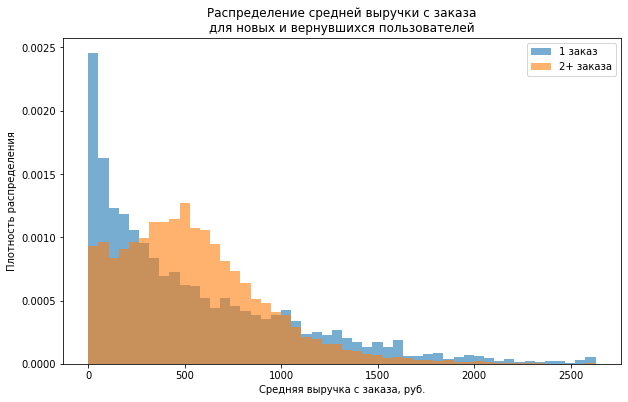

In [60]:
#Сравнительные гистограммы средней выручки
plt.figure(figsize=(10, 6))

plt.hist(
    one_order_users['avg_revenue_rub'],
    bins=50,
    alpha=0.6,
    density=True,
    label='1 заказ'
)

plt.hist(
    repeat_users['avg_revenue_rub'],
    bins=50,
    alpha=0.6,
    density=True,
    label='2+ заказа'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа\nдля новых и вернувшихся пользователей')
plt.legend()

plt.show()


In [61]:
one_order_users['avg_revenue_rub'].describe()

count    8362.000000
mean      545.523340
std       519.366822
min         0.000000
25%       133.037500
50%       378.435000
75%       829.210000
max      2628.421739
Name: avg_revenue_rub, dtype: float64

In [62]:
repeat_users['avg_revenue_rub'].describe()

count    13250.000000
mean       544.837964
std        369.345180
min          0.000000
25%        271.562083
50%        496.000000
75%        745.270000
max       2628.421739
Name: avg_revenue_rub, dtype: float64

**Связь средней выручки с заказа и повторных покупок**

Для анализа пользователи были разделены на две группы:
- пользователи, совершившие **один заказ**;
- пользователи, совершившие **два и более заказов**.

Сравнение распределений средней выручки с заказа показало следующие результаты:

- **Средняя выручка** в обеих группах практически одинакова:
  - 1 заказ — около **545 руб.**
  - 2+ заказов — около **544 руб.**

- **Медианная выручка** у вернувшихся пользователей заметно выше:
  - 1 заказ — **378 руб.**
  - 2+ заказов — **498 руб.**

- Основная масса пользователей с **одним заказом** сконцентрирована в диапазоне **100–400 руб.**,  
  тогда как у вернувшихся пользователей распределение смещено вправо — в диапазон **300–800 руб.**

- У пользователей с одним заказом наблюдается **больший разброс значений**, включая более низкие и экстремальные значения выручки.

**Вывод:**  
Пользователи, совершающие повторные заказы, в среднем оформляют **более дорогие заказы**, особенно это видно по медиане и основн


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [63]:
# Пользователи, совершившие 2–4 заказа
group_2_4 = user_profile.loc[user_profile['orders_count'].between(2, 4), 'avg_revenue_rub']
# Пользователи, совершившие 5 и более заказов
group_5_plus = user_profile.loc[user_profile['orders_count'] >= 5, 'avg_revenue_rub']

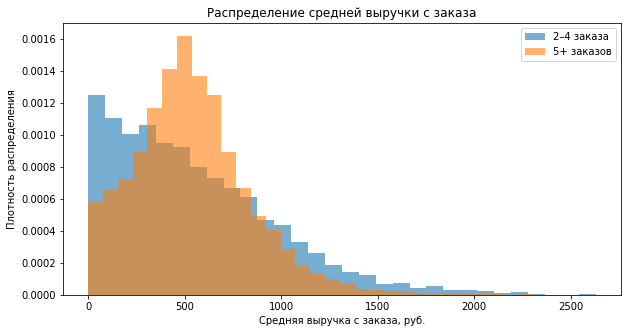

In [64]:
# Строим гистограммы
plt.figure(figsize=(10, 5))

plt.hist(
    group_2_4,
    bins=30,
    alpha=0.6,
    density=True,
    label='2–4 заказа'
)

plt.hist(
    group_5_plus,
    bins=30,
    alpha=0.6,
    density=True,
    label='5+ заказов'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()

plt.show()

In [65]:
group_2_4.describe()

count    7139.000000
mean      552.024239
std       420.178567
min         0.000000
25%       219.441667
50%       472.105000
75%       798.550000
max      2628.421739
Name: avg_revenue_rub, dtype: float64

In [66]:
group_5_plus.describe()

count    6111.000000
mean      536.442804
std       299.032889
min         0.000000
25%       331.389012
50%       512.946000
75%       701.032071
max      2299.869022
Name: avg_revenue_rub, dtype: float64

#### Вывод

Было проведено сравнение распределения средней выручки с заказа (`avg_revenue_rub`) для двух групп пользователей:
- пользователи, совершившие **2–4 заказа**;
- пользователи, совершившие **5 и более заказов**.

**Общее сравнение групп**
Обе группы демонстрируют **сопоставимый уровень средней выручки с заказа**:
- среднее значение:
  - 2–4 заказа — около **552 руб.**;
  - 5+ заказов — около **536 руб.**.
- медианное значение:
  - 2–4 заказа — около **472 руб.**;
  - 5+ заказов — около **513 руб.**.

**Различия в распределениях**
- У пользователей с **2–4 заказами** наблюдается **больший разброс значений** средней выручки и более длинный правый хвост распределения, что указывает на наличие разовых дорогих заказов.
- У пользователей с **5 и более заказами** распределение более **сконцентрировано в среднем ценовом диапазоне**, медиана выше, а разброс меньше, что говорит о большей стабильности покупок.

**Интерпретация**
Существенных различий по уровню **средней выручки с заказа** между группами не выявлено.  
Основное различие заключается не в размере заказов, а в **регулярности и стабильности покупок**: пользователи с 5 и более заказами формируют более устойчивый паттерн потребления, тогда как у пользователей с 2–4 заказами чаще встречаются разовые покупки с высокой стоимостью.

Таким образом, рост лояльности выражается скорее в **частоте и предсказуемости заказов**, а не в увеличении средней выручки с одного заказа.


<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Можно чуть структурировать интерпретацию. Начни с общего сравнения (чем отличаются группы в целом), затем подчеркни ключевые различия в диапазонах (например, что возвращающиеся чаще в зоне от...–до... ₽, а однократные имеют больший разброс), и завершай возможными причинами — например, что нулевая выручка у однократных, вероятно, связана с возвратами, а крупные заказы — с разовыми покупками для групп.
    
Еще можно добавить расчёты медины и среднего, чтобы понимать - имеется ли смещение и в какую сторону   
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Рекомендация учтена.
<div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [67]:
# Распределение среднего количества билетов
user_profile['avg_tickets_count'].describe()

count    21612.000000
mean         2.740301
std          0.907112
min          1.000000
25%          2.000000
50%          2.750000
75%          3.090909
max          6.000000
Name: avg_tickets_count, dtype: float64

In [68]:
# Сегментация по среднему числу билетов
user_profile['tickets_segment'] = pd.cut(
    user_profile['avg_tickets_count'],
    bins=[1, 2, 3, 5, float('inf')],
    right=True,
    include_lowest=True,
    labels=[
        '1–2 билета',
        '2–3 билета',
        '3–5 билетов',
        '5+ билетов'
    ]
)

In [69]:
#Подсчёт пользователей и доли возвратов по сегментам
tickets_returns = (
    user_profile
    .groupby('tickets_segment')
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

tickets_returns

,tickets_segment,users_count,return_rate
0,1–2 билета,6153,0.401430
1,2–3 билета,9928,0.742446
2,3–5 билетов,5352,0.626868
3,5+ билетов,179,0.301676


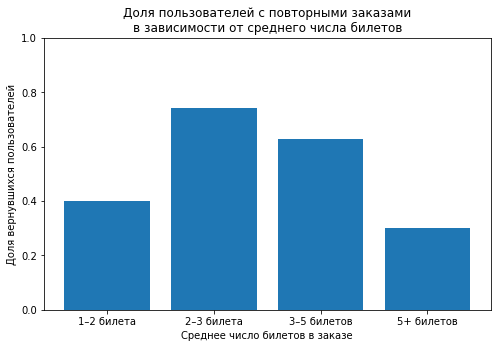

In [70]:
#График доли возвратов
plt.figure(figsize=(8, 5))
plt.bar(
    tickets_returns['tickets_segment'],
    tickets_returns['return_rate']
)
plt.title('Доля пользователей с повторными заказами\nв зависимости от среднего числа билетов')
plt.ylabel('Доля вернувшихся пользователей')
plt.xlabel('Среднее число билетов в заказе')
plt.ylim(0, 1)
plt.show()

**Влияние среднего количества билетов в заказе**

Большинство пользователей покупают в среднем **2–3 билета**: медианное значение `avg_tickets_count` составляет **2.75**, при этом 75% пользователей покупают не более **3.1 билета**. Значения выше **5 билетов** встречаются редко и относятся к небольшому числу пользователей.

**Сегментация по среднему количеству билетов в заказе**

При сегментации пользователей по среднему количеству билетов получены следующие результаты:

- **1–2 билета** — около 6 тыс. пользователей, доля повторных заказов ~40%;
- **2–3 билета** — самый массовый сегмент (более 10 тыс. пользователей) и **наивысшая доля возврата (~75%)**;
- **3–5 билетов** — сегмент среднего размера, доля возврата ~63%;
- **5+ билетов** — очень малочисленный сегмент, доля повторных заказов ниже 35%.

Распределение пользователей **неравномерно**: основная концентрация приходится на сегменты **2–3** и **3–5 билетов**, тогда как покупки **5+ билетов** являются редким сценарием.

**Интерпретация и возможные причины**

Наиболее успешным сегментом с точки зрения возврата являются пользователи, которые в среднем покупают **2–3 билета**. Вероятно, это небольшие группы или семьи, которые регулярно посещают мероприятия вместе, что формирует устойчивый поведенческий паттерн и более высокую лояльность.

Пользователи с **5 и более билетами**, напротив, могут совершать **разовые групповые покупки** (например, для организации, класса или корпоративного мероприятия). Такие заказы имеют больший размер, но носят эпизодический характер, что объясняет более низкую долю повторных покупок.

Сегменты **1–2 билета** и **5+ билетов** демонстрируют более низкую вовлечённость. При этом сегмент **5+ билетов** следует интерпретировать с осторожностью из-за малого объёма данных.

Таким образом, диапазон **2–3 билета** можно рассматривать как ключевую «точку роста» для программ удержания и развития лояльности пользователей.



<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Можно чуть развить вывод — предположить, почему пользователи, покупающие 2–3 билета, возвращаются чаще. Например, это могут быть небольшие компании или семьи, которые чаще ходят на мероприятия вместе, а значит, лояльность у них выше. А вот пользователи с 5+ билетами, вероятно, совершают разовые групповые покупки (например, для организации или класса), поэтому возвращаются реже
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Чуть изменил
<div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [71]:
# День недели первого заказа
user_profile['first_order_weekday'] = user_profile['first_order_dt'].dt.dayofweek

# Для удобства добавим названия дней недели
weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
user_profile['first_order_weekday_name'] = user_profile['first_order_weekday'].map(weekday_map)

In [72]:
# Число пользователей и доля возвратов
weekday_returns = (
    user_profile
    .groupby('first_order_weekday_name')
    .agg(
        users_count=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

In [73]:
# Сортировка по порядку дней недели
weekday_returns['weekday_order'] = weekday_returns['first_order_weekday_name'].map(
    {v: k for k, v in weekday_map.items()}
)
weekday_returns = weekday_returns.sort_values('weekday_order')

weekday_returns

,first_order_weekday_name,users_count,return_rate,weekday_order
2,Понедельник,2917,0.629757,0
1,Вторник,3176,0.618388,1
4,Среда,3061,0.622346,2
6,Четверг,3111,0.594664,3
3,Пятница,3255,0.597542,4
5,Суббота,3317,0.627676,5
0,Воскресенье,2775,0.600721,6


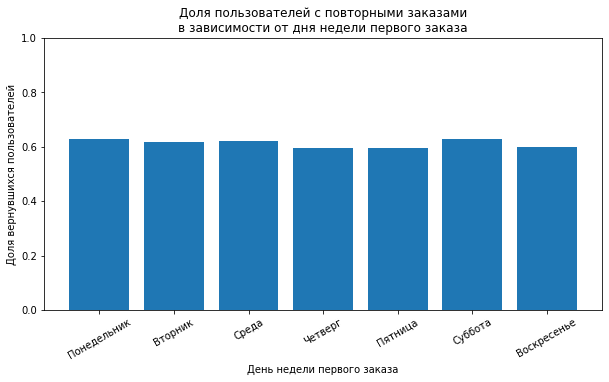

In [74]:
plt.figure(figsize=(10, 5))
plt.bar(
    weekday_returns['first_order_weekday_name'],
    weekday_returns['return_rate']
)

plt.title('Доля пользователей с повторными заказами\nв зависимости от дня недели первого заказа')
plt.xlabel('День недели первого заказа')
plt.ylabel('Доля вернувшихся пользователей')
plt.xticks(rotation=30)
plt.ylim(0, 1)

plt.show()

**Влияние дня недели первой покупки**

Пользователи распределены по дням недели первого заказа **достаточно равномерно**: в каждый день первую покупку совершили примерно 2.8–3.5 тыс. пользователей, что позволяет корректно сравнивать долю возвратов между сегментами без искажений из-за малого объёма данных.

Доля пользователей, совершивших повторные заказы, находится в диапазоне ~59–64% и слабо зависит от дня недели первой покупки:

- Понедельник–среда — стабильная доля возвратов на уровне 62–63%

- Четверг и пятница — немного более низкие значения (~59–60%)

- Суббота — наивысшая доля повторных заказов (~64%)

- Воскресенье — около 60%

Несмотря на небольшое преимущество выходных дней, различия между днями недели невелики. Ни один из дней не выделяется с существенно более высокой вероятностью возврата.

Вывод: день недели первой покупки оказывает слабое влияние на вероятность повторного заказа. Поведение пользователей после первой покупки остаётся схожим вне зависимости от того, в какой день недели был сделан первый заказ.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Когда планируют досуг, но возвращаемость остаётся примерно одинаковой — это говорит о том, что день недели первой покупки не влияет на лояльность, а повторное использование сервиса определяется скорее качеством опыта и интересом к мероприятиям

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [75]:
# Пользователи с 2–4 заказами
group_2_4 = user_profile[
    (user_profile['orders_count'] >= 2) &
    (user_profile['orders_count'] <= 4)
]

# Пользователи с 5 и более заказами
group_5_plus = user_profile[
    user_profile['orders_count'] >= 5
]

In [76]:
group_2_4['avg_days_between'].describe()

count    7139.000000
mean       21.327952
std        28.496835
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between, dtype: float64

In [77]:
group_5_plus['avg_days_between'].describe()

count    6111.000000
mean        9.907585
std         7.805194
min         0.000000
25%         3.884034
50%         8.125000
75%        14.105556
max        37.500000
Name: avg_days_between, dtype: float64

**Влияние среднего интервала между заказами**

Средний интервал между покупками заметно различается у пользователей с разным числом заказов.

Для пользователей, совершивших 2–4 заказа, характерны более длинные промежутки между покупками:

- среднее значение — ~21 день;

- медиана — 9 дней;

- у 25% пользователей интервал равен 0 дней, что указывает на повторные покупки в один и тот же день;

- 75% пользователей совершают следующую покупку в течение 34 дней;

- наблюдаются редкие, но длинные интервалы до 148 дней, что увеличивает разброс значений.

Для пользователей, совершивших 5 и более заказов, покупки происходят значительно чаще:

- средний интервал — около 9.6 дня;

- медиана — 7.8 дня;

- 75% пользователей возвращаются в течение 14 дней;

- максимальный интервал существенно ниже — ~38 дней, распределение более компактное.

Таким образом, пользователи с большим числом заказов характеризуются более короткими и стабильными интервалами между покупками, тогда как у пользователей с 2–4 заказами поведение менее регулярное и с более длинными паузами между заказами.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
<b>Отлично ✅:</b> По расчетам все верно!
    
</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

<b>Рекомендации💡:</b>  Важно иметь в виду, что среднее значение довольно сильно зависит от характера распределения, если есть какие-то сильные выбросы, они могут утянуть среднее значение вверх, хотя основаня масса значений будет гораздо ниже. Поэтому здесь важно было бы построить в том числе гистограммы, наложить их друг на друга (как мы это делали при сравнении выручки), чтобы видеть всю картину в данных.
 
</div>

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [78]:
# Выбираем признаки профиля пользователя
profile_cols = [
    'orders_count',
    'first_event_type',
    'first_device',
    'first_region',
    'first_service',
    'avg_revenue_rub',
    'avg_tickets_count'
]

phik_corr = user_profile[profile_cols].phik_matrix(
    interval_cols=['orders_count', 'avg_revenue_rub', 'avg_tickets_count']
)

phik_corr

,orders_count,first_event_type,first_device,first_region,first_service,avg_revenue_rub,avg_tickets_count
orders_count,1.000000,0.030830,0.025590,0.122100,0.035153,0.222458,0.340453
first_event_type,0.030830,1.000000,0.061744,0.508052,0.587127,0.328452,0.096537
first_device,0.025590,0.061744,1.000000,0.114537,0.083052,0.075082,0.061394
first_region,0.122100,0.508052,0.114537,1.000000,0.696507,0.358509,0.138737
first_service,0.035153,0.587127,0.083052,0.696507,1.000000,0.379402,0.097473
avg_revenue_rub,0.222458,0.328452,0.075082,0.358509,0.379402,1.000000,0.481710
avg_tickets_count,0.340453,0.096537,0.061394,0.138737,0.097473,0.481710,1.000000


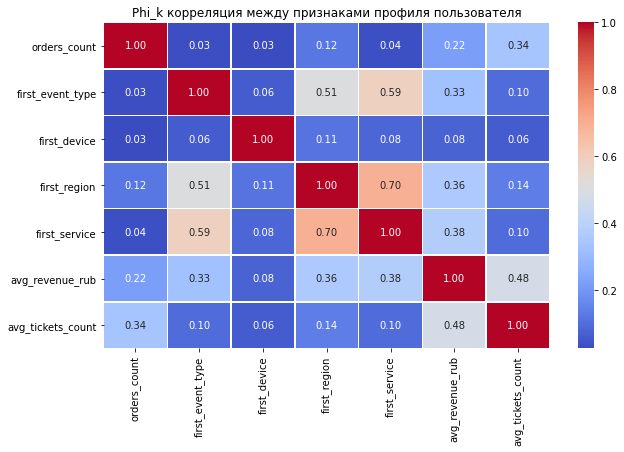

In [79]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Phi_k корреляция между признаками профиля пользователя')
plt.show()

In [80]:
user_profile['orders_count'].value_counts().head(10)

1     8362
2     3569
3     2172
4     1398
5      968
6      704
7      540
8      452
9      385
10     287
Name: orders_count, dtype: int64

In [81]:
#Создать сегменты по числу заказов
user_profile['orders_segment'] = pd.cut(
    user_profile['orders_count'],
    bins=[0, 1, 4, user_profile['orders_count'].max()],
    labels=['1 заказ', '2–4 заказа', '5+ заказов']
)

user_profile['orders_segment'].value_counts()


1 заказ       8362
2–4 заказа    7139
5+ заказов    6111
Name: orders_segment, dtype: int64

In [82]:
segment_cols = [
    'orders_segment',
    'first_event_type',
    'first_device',
    'first_region',
    'first_service',
    'avg_revenue_rub',
    'avg_tickets_count'
]

phik_corr_segmented = user_profile[segment_cols].phik_matrix(
    interval_cols=['avg_revenue_rub', 'avg_tickets_count']
)

phik_corr_segmented

,orders_segment,first_event_type,first_device,first_region,first_service,avg_revenue_rub,avg_tickets_count
orders_segment,1.000000,0.041644,0.017567,0.123670,0.082094,0.324914,0.584348
first_event_type,0.041644,1.000000,0.061744,0.508052,0.587127,0.328452,0.096537
first_device,0.017567,0.061744,1.000000,0.114537,0.083052,0.075082,0.061394
first_region,0.123670,0.508052,0.114537,1.000000,0.696507,0.358509,0.138737
first_service,0.082094,0.587127,0.083052,0.696507,1.000000,0.379402,0.097473
avg_revenue_rub,0.324914,0.328452,0.075082,0.358509,0.379402,1.000000,0.481710
avg_tickets_count,0.584348,0.096537,0.061394,0.138737,0.097473,0.481710,1.000000


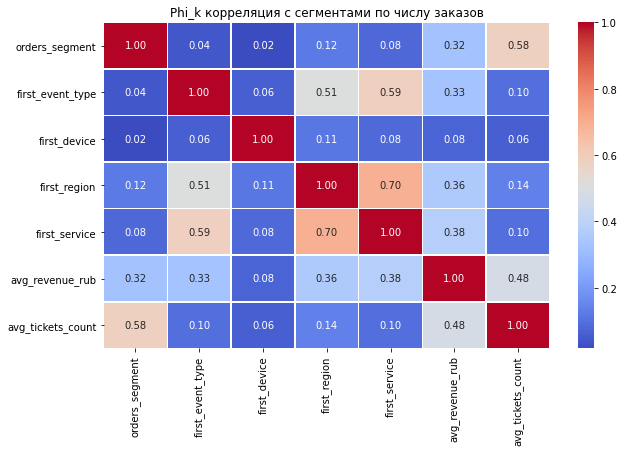

In [83]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    phik_corr_segmented,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Phi_k корреляция с сегментами по числу заказов')
plt.show()


**Корреляционный анализ (phi_k)**

Для оценки связей между признаками профиля пользователя и количеством заказов использован коэффициент phi_k. Интервальные признаки: `orders_count`, `avg_revenue_rub`, `avg_tickets_count`.

По матрице phik_corr видно, что связи `orders_count` с признаками первого заказа в целом слабые (значения близки к 0).

Пользователи были сегментированы по числу заказов (`orders_segment`: 1 заказ, 2–4 заказа, 5+ заказов) и корреляция рассчитана повторно (phik_corr_segmented).

В сегментированном варианте наиболее заметная связь с `orders_segment` наблюдается у:

`avg_tickets_count` (phi_k ≈ 0.39)

`avg_revenue_rub` (phi_k ≈ 0.33)

Категориальные признаки первого заказа (тип события, регион, оператор, устройство) остаются слабо связаны с количеством заказов.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
С этим заданием тоже справились!

</div>


### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### 5. Общий вывод и рекомендации

#### Кратко о данных и подготовке

В работе использовались данные о заказах пользователей **Яндекс Афиши**, на основе которых был построен **профиль пользователя**.

В ходе предобработки данных:
- проверены и обработаны пропуски;
- приведены типы данных (даты, числовые поля);
- удалены выбросы по выручке (фильтрация по **99-му перцентилю**);
- рассчитаны агрегированные признаки: **число заказов**, **средняя выручка**, **среднее число билетов**, **интервалы между покупками**;
- пользователи сегментированы по числу заказов и поведенческим характеристикам.

В итоговой выборке — **21 854 пользователя**.

---

#### Основные результаты анализа

**Распределение пользователей по заказам** неравномерное:  
большинство совершают **1–2 заказа**, однако значимая доля пользователей делает **5 и более заказов**.

**Признаки первого заказа:**
- наиболее массовые «точки входа» — **концерты** и **мобильные устройства**;
- различия в возврате по типу мероприятия и устройству **незначительные**;
- гипотеза о том, что **спортивные мероприятия дают больший возврат**, **не подтвердилась**.

**Выручка и билеты:**
- средняя выручка с заказа почти не различается между разовыми и возвращающимися пользователями;
- наибольшая доля повторных заказов наблюдается у пользователей, покупающих в среднем **2–3 билета**;
- сегменты **1–2 билета** и **5+ билетов** демонстрируют более низкое удержание.

**Временные характеристики:**
- день недели первого заказа **слабо влияет** на вероятность возврата;
- пользователи с **5+ заказами** имеют значительно **меньший средний интервал между покупками**, чем пользователи с 2–4 заказами.

**Корреляционный анализ (phi_k)** показал:
- слабую связь числа заказов с признаками первого заказа;
- наиболее заметную связь числа заказов с:
  - **avg_tickets_count** (phi_k ≈ **0.39**);
  - **avg_revenue_rub** (phi_k ≈ **0.33**).

---

#### Рекомендации заказчику

- Сфокусироваться на пользователях, покупающих **2–3 билета** — это самый массовый и наиболее «возвращаемый» сегмент.
- Использовать **частоту покупок** и **интервалы между заказами** как ключевые сигналы удержания (триггерные рассылки, напоминания).
- Не делать ставку только на тип первого мероприятия — его влияние на возврат ограничено.
- Усилить работу с пользователями сегмента **1–2 билета** — это потенциальная зона роста повторных покупок.
- Для моделей прогнозирования возврата опираться прежде всего на **поведенческие признаки**, а не только на характеристики первого заказа.


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
С задачей справились! Все ключевые моменты отражены, что позволяет быстро ознакомиться с процессом работы и результатом, не вдаваясь в технический детали. Здорово, что завершаешь проект рекомендациями, основанные на выявленных закономерностях. Предложенные рекомендации логично следуют из анализа и могут быть непосредственно реализованы в маркетинговых стратегиях подогревания и удержания. 

</div>

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/gabdullinbr/afisha-loyalty-analysis

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
Габдуллин, к сожалению не увидел ссылки на репозиторий гитхаба (не забудь, пожалуйста, засекретить подключение к БД)
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Добавил, не заметил, что не было добавлено
<div>